In [1]:
cd ..

/Users/muhammadfarooq/Codebase/thesis-experiment/Pith2Bark


In [2]:
from src.winner import winner_model_rings
from src.damage import merge_df
from src.damage import read_damage_min_max
from src.damage import read_damage_mean

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import unique

from tensorflow.keras.layers import Conv1D, Dense, MaxPool1D, MaxPooling1D, Dropout, Flatten
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

from keras.layers import BatchNormalization

2023-04-10 22:38:55.461655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import warnings
warnings.simplefilter('ignore')

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

random_state = 47
np.random.seed(random_state)

# Visual

In [5]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'],
                 color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
                 color=colors[n], label='Val ' + label,
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

# Configuration

In [6]:
epochs, batch_size = 50, 32
# 50, 32
# 500, 50
kf = KFold(n_splits=3, shuffle=True, random_state=42)

accuracy_sixteen_min_max = []
accuracy_thirtytwo_min_max = []
accuracy_sixteen_mean = []
accuracy_thirtytwo_mean = []

# mode = max for monitro val_accuracy and val_prc

early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#columns to drop
columns = ['image', 'algo']

2023-04-10 22:38:59.645612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Prepare Dataset

In [7]:
mse_url = "output/ringsranking_mse_sixteen.csv"
rings_url = "output/ringsranking_rings_sixteen.csv"
df_ringsranking_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/ringsranking_mse_thirtytwo.csv"
rings_url = "output/ringsranking_rings_thirtytwo.csv"
df_ringsranking_thirtytwo = winner_model_rings(mse_url, rings_url)

Polar Pith Canny(blur otsu) 12.829318845239923 (subseq)
Polar Pith Canny(blur otsu) 12.88055458721076 (subseq)


In [8]:
mse_url = "output/pine_mse_sixteen.csv"
rings_url = "output/pine_rings_sixteen.csv"
df_pine_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/pine_mse_thirtytwo.csv"
rings_url = "output/pine_rings_thirtytwo.csv"
df_pine_thirtytwo = winner_model_rings(mse_url, rings_url)

Polar Pith Canny(blur triangle) 19.888455438324574 (peaks)
Polar Pith Canny(blur triangle) 19.591747084408897 (peaks)


In [9]:
mse_url = "output/fur_mse_sixteen.csv"
rings_url = "output/fur_rings_sixteen.csv"
df_fur_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/fur_mse_thirtytwo.csv"
rings_url = "output/fur_rings_thirtytwo.csv"
df_fur_thirtytwo = winner_model_rings(mse_url, rings_url)

Polar Pith Canny(blur triangle) 13.428984012468806 (peaks)
Polar Pith Canny(blur triangle) 13.688767879960144 (peaks)


In [10]:
mse_url = "output/tracy_mse_sixteen.csv"
rings_url = "output/tracy_rings_sixteen.csv"
df_tracy_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/tracy_mse_thirtytwo.csv"
rings_url = "output/tracy_rings_thirtytwo.csv"
df_tracy_thirtytwo = winner_model_rings(mse_url, rings_url)

Polar Canny(triangle) 39.683736416974455 (peaks)
Polar Pith Canny(triangle) 39.48914666858598 (peaks)


In [11]:
mse_url = "output/data_mse_sixteen.csv"
rings_url = "output/data_rings_sixteen.csv"
df_data_sixteen = winner_model_rings(mse_url, rings_url)

mse_url = "output/data_mse_thirtytwo.csv"
rings_url = "output/data_rings_thirtytwo.csv"
df_data_thirtytwo = winner_model_rings(mse_url, rings_url)

Canny(triangle) 18.789996216404624 (subseq)
Canny(triangle) 18.871624925897343 (subseq)


In [12]:
#damage
damage_sixteen_url = "damage/damage_sixteen.csv"
damage_thirtytwo_url = "damage/damage_thirtytwo.csv"

#merge
df_merge_sixteen = merge_df(df_ringsranking_sixteen, df_pine_sixteen, df_fur_sixteen, df_tracy_sixteen, df_data_sixteen)
df_merge_thirtytwo = merge_df(df_ringsranking_thirtytwo, df_pine_thirtytwo, df_fur_thirtytwo, df_tracy_thirtytwo, df_data_thirtytwo)

df_damage_sixteen_min_max = read_damage_min_max(damage_sixteen_url, df_merge_sixteen)
df_damage_thirtytwo_min_max = read_damage_min_max(damage_thirtytwo_url, df_merge_thirtytwo)

df_damage_sixteen_mean = read_damage_mean(damage_sixteen_url, df_merge_sixteen)
df_damage_thirtytwo_mean = read_damage_mean(damage_thirtytwo_url, df_merge_thirtytwo)

In [13]:
#df_damage_sixteen_min_max

In [14]:
#df_damage_thirtytwo_min_max

In [15]:
#df_damage_sixteen_mean

In [16]:
#df_damage_thirtytwo_mean

In [17]:
#STOP

# Dense Model

In [18]:
def layerFactory(type, nodes, activation):
        if type == 'Dense':
            if not activation:
                return Dense(units=nodes)
            else:
                return Dense(units=nodes, activation=activation)
        if type == 'Conv1D':
            if not activation:
                return Conv1D(units=nodes)
            else:
                return Conv1D(units=nodes, activation=activation)
        if type == 'MaxPooling1D':
            if not activation:
                return MaxPooling1D(units=nodes)
            else:
                return MaxPooling1D(units=nodes, activation=activation)
        if type == 'Dropout':
            return Dropout(rate=nodes)
        if type == 'Flatten':
            if not activation:
                return Flatten(units=nodes)
            else:
                return Flatten(units=nodes, activation=activation)

        return Dense(units=nodes, activation=activation)

In [19]:
class DenseModel():
    def __init__(self, layers, input_dim, metrics=METRICS, output_bias=None):
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)

        model = Sequential([
            InputLayer(input_shape=(input_dim))
        ])

        for layer in layers:
            model.add(layerFactory(layer['type'], layer['nodes'], layer['activation']))

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=metrics)
        
        self.model = model
    
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, callback):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[callback])
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X): #X_train X_test
        predictions = self.model.predict(X)
        return predictions
    
    def summary(self):
        self.model.summary()
        
    def metrics_names(self):
        return self.model.metrics_names

## 1 Dense Model with 16 Lines

### Dataset

In [20]:
# prepare dataset
df = df_damage_sixteen_min_max.drop(columns=columns)

In [21]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 20)
Training labels shape: (106,) 

Validation features shape: (27, 20)
Validation labels shape: (27,) 

Test features shape: (15, 20)
Test labels shape: (15,) 



### Model

In [22]:
input_dim = X_train.shape[1]
units = 16
activation = 'relu'
output_size = 1
output_activation = 'sigmoid'
kernel_initializer = 'he_uniform'

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation }
]

model = DenseModel(LAYERS, input_dim)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                336       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 166ms/step - loss: 0.7384 - tp: 3.0000 - fp: 15.0000 - tn: 53.0000 - fn: 35.0000 - accuracy: 0.5283 - precision: 0.1667 - recall: 0.0789 - auc: 0.2384 - prc: 0.2539 - val_loss: 0.7277 - val_tp: 2.0000 - val_fp: 6.0000 - val_tn: 11.0000 - val_fn: 8.0000 - val_accuracy: 0.4815 - val_precision: 0.2500 - val_recall: 0.2000 - val_auc: 0.3265 - val_prc: 0.3222
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 0.7331 - tp: 3.0000 - fp: 14.0000 - tn: 54.0000 - fn: 35.0000 - accuracy: 0.5377 - precision: 0.1765 - recall: 0.0789 - auc: 0.2494 - prc: 0.2571 - val_loss: 0.7215 - val_tp: 2.0000 - val_fp: 6.0000 - val_tn: 11.0000 - val_fn: 8.0000 - val_accuracy: 0.4815 - val_precision: 0.2500 - val_recall: 0.2000 - val_auc: 0.3441 - val_prc: 0.3272
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 0.7283 - tp: 3.0000 - fp: 13.0000 - tn: 55.0000 - fn: 35.0000 - accuracy: 0.5472 - precision: 0.1875 - recall:

4/4 [==============================] - 0s 21ms/step - loss: 0.6546 - tp: 7.0000 - fp: 6.0000 - tn: 62.0000 - fn: 31.0000 - accuracy: 0.6509 - precision: 0.5385 - recall: 0.1842 - auc: 0.5851 - prc: 0.4475 - val_loss: 0.6243 - val_tp: 4.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 6.0000 - val_accuracy: 0.7037 - val_precision: 0.6667 - val_recall: 0.4000 - val_auc: 0.7000 - val_prc: 0.5988
Epoch 22/50
4/4 [==============================] - 0s 20ms/step - loss: 0.6511 - tp: 8.0000 - fp: 6.0000 - tn: 62.0000 - fn: 30.0000 - accuracy: 0.6604 - precision: 0.5714 - recall: 0.2105 - auc: 0.6097 - prc: 0.4658 - val_loss: 0.6194 - val_tp: 4.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 6.0000 - val_accuracy: 0.7037 - val_precision: 0.6667 - val_recall: 0.4000 - val_auc: 0.7118 - val_prc: 0.6053
Epoch 23/50
4/4 [==============================] - 0s 18ms/step - loss: 0.6474 - tp: 10.0000 - fp: 6.0000 - tn: 62.0000 - fn: 28.0000 - accuracy: 0.6792 - precision: 0.6250 - recall: 0.2632 - au

4/4 [==============================] - 0s 19ms/step - loss: 0.5787 - tp: 22.0000 - fp: 6.0000 - tn: 62.0000 - fn: 16.0000 - accuracy: 0.7925 - precision: 0.7857 - recall: 0.5789 - auc: 0.8466 - prc: 0.7995 - val_loss: 0.5264 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 1.0000 - val_accuracy: 0.8889 - val_precision: 0.8182 - val_recall: 0.9000 - val_auc: 0.9441 - val_prc: 0.8902
Epoch 42/50
4/4 [==============================] - 0s 21ms/step - loss: 0.5750 - tp: 23.0000 - fp: 6.0000 - tn: 62.0000 - fn: 15.0000 - accuracy: 0.8019 - precision: 0.7931 - recall: 0.6053 - auc: 0.8516 - prc: 0.8100 - val_loss: 0.5214 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 1.0000 - val_accuracy: 0.8889 - val_precision: 0.8182 - val_recall: 0.9000 - val_auc: 0.9529 - val_prc: 0.9102
Epoch 43/50
4/4 [==============================] - 0s 18ms/step - loss: 0.5712 - tp: 23.0000 - fp: 6.0000 - tn: 62.0000 - fn: 15.0000 - accuracy: 0.8019 - precision: 0.7931 - recall: 0.6053 - 

In [24]:
early_stopping.stopped_epoch

0

In [25]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [26]:
#plot_metrics(history)
#plt.show()

In [27]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_sixteen_min_max.append(value)

1/1 [==============================] - 0s 21ms/step
loss :  0.45920759439468384
tp :  5.0
fp :  0.0
tn :  9.0
fn :  1.0
accuracy :  0.9333333373069763
precision :  1.0
recall :  0.8333333134651184
auc :  1.0
prc :  1.0


True Negatives:  9
False Positives:  0
False Negatives:  1
True Positives:  5
Total:  6


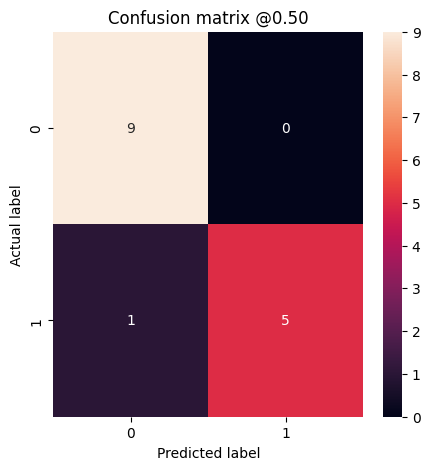

In [28]:
plot_cm(y_test, predictions_test)
plt.show()

In [29]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [30]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [31]:
#STOP

## 2 Dense Model with 32 Lines

### Dataset

In [32]:
df = df_damage_thirtytwo_min_max.drop(columns=columns)

In [33]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 36)
Training labels shape: (106,) 

Validation features shape: (27, 36)
Validation labels shape: (27,) 

Test features shape: (15, 36)
Test labels shape: (15,) 



### Model

In [34]:
input_dim = X_train.shape[1]
units = 16
activation = 'relu'
output_size = 1
output_activation = 'sigmoid'
kernel_initializer = 'he_uniform'

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation }
]

model = DenseModel(LAYERS, input_dim)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                592       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 180ms/step - loss: 1.0042 - tp: 11.0000 - fp: 48.0000 - tn: 22.0000 - fn: 40.0000 - accuracy: 0.2727 - precision: 0.1864 - recall: 0.2157 - auc: 0.2099 - prc: 0.3019 - val_loss: 1.0227 - val_tp: 4.0000 - val_fp: 11.0000 - val_tn: 3.0000 - val_fn: 9.0000 - val_accuracy: 0.2593 - val_precision: 0.2667 - val_recall: 0.3077 - val_auc: 0.1291 - val_prc: 0.3108
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 0.9929 - tp: 6.0000 - fp: 48.0000 - tn: 13.0000 - fn: 39.0000 - accuracy: 0.1792 - precision: 0.1111 - recall: 0.1333 - auc: 0.0956 - prc: 0.2598 - val_loss: 1.0087 - val_tp: 4.0000 - val_fp: 11.0000 - val_tn: 3.0000 - val_fn: 9.0000 - val_accuracy: 0.2593 - val_precision: 0.2667 - val_recall: 0.3077 - val_auc: 0.1264 - val_prc: 0.3105
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 0.9819 - tp: 6.0000 - fp: 48.0000 - tn: 13.0000 - fn: 39.0000 - accuracy: 0.1792 - precision: 0.1111 - recall

Epoch 21/50
4/4 [==============================] - 0s 18ms/step - loss: 0.8196 - tp: 9.0000 - fp: 42.0000 - tn: 19.0000 - fn: 36.0000 - accuracy: 0.2642 - precision: 0.1765 - recall: 0.2000 - auc: 0.1741 - prc: 0.2845 - val_loss: 0.7971 - val_tp: 6.0000 - val_fp: 11.0000 - val_tn: 3.0000 - val_fn: 7.0000 - val_accuracy: 0.3333 - val_precision: 0.3529 - val_recall: 0.4615 - val_auc: 0.3242 - val_prc: 0.3756
Epoch 22/50
4/4 [==============================] - 0s 18ms/step - loss: 0.8122 - tp: 8.0000 - fp: 42.0000 - tn: 19.0000 - fn: 37.0000 - accuracy: 0.2547 - precision: 0.1600 - recall: 0.1778 - auc: 0.1814 - prc: 0.2903 - val_loss: 0.7877 - val_tp: 6.0000 - val_fp: 10.0000 - val_tn: 4.0000 - val_fn: 7.0000 - val_accuracy: 0.3704 - val_precision: 0.3750 - val_recall: 0.4615 - val_auc: 0.3462 - val_prc: 0.3861
Epoch 23/50
4/4 [==============================] - 0s 19ms/step - loss: 0.8046 - tp: 8.0000 - fp: 41.0000 - tn: 20.0000 - fn: 37.0000 - accuracy: 0.2642 - precision: 0.1633 - recal

Epoch 41/50
4/4 [==============================] - 0s 18ms/step - loss: 0.6954 - tp: 19.0000 - fp: 26.0000 - tn: 35.0000 - fn: 26.0000 - accuracy: 0.5094 - precision: 0.4222 - recall: 0.4222 - auc: 0.5029 - prc: 0.5356 - val_loss: 0.6493 - val_tp: 9.0000 - val_fp: 5.0000 - val_tn: 9.0000 - val_fn: 4.0000 - val_accuracy: 0.6667 - val_precision: 0.6429 - val_recall: 0.6923 - val_auc: 0.7225 - val_prc: 0.7262
Epoch 42/50
4/4 [==============================] - 0s 18ms/step - loss: 0.6900 - tp: 19.0000 - fp: 24.0000 - tn: 37.0000 - fn: 26.0000 - accuracy: 0.5283 - precision: 0.4419 - recall: 0.4222 - auc: 0.5182 - prc: 0.5589 - val_loss: 0.6431 - val_tp: 9.0000 - val_fp: 5.0000 - val_tn: 9.0000 - val_fn: 4.0000 - val_accuracy: 0.6667 - val_precision: 0.6429 - val_recall: 0.6923 - val_auc: 0.7308 - val_prc: 0.7338
Epoch 43/50
4/4 [==============================] - 0s 19ms/step - loss: 0.6848 - tp: 19.0000 - fp: 23.0000 - tn: 38.0000 - fn: 26.0000 - accuracy: 0.5377 - precision: 0.4524 - reca

In [36]:
early_stopping.stopped_epoch

0

In [37]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [38]:
#plot_metrics(history)
#plt.show()

In [39]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_thirtytwo_min_max.append(value)

1/1 [==============================] - 0s 22ms/step
loss :  0.5777769684791565
tp :  4.0
fp :  1.0
tn :  8.0
fn :  2.0
accuracy :  0.800000011920929
precision :  0.800000011920929
recall :  0.6666666865348816
auc :  0.9166666269302368
prc :  0.8846259117126465


True Negatives:  8
False Positives:  1
False Negatives:  2
True Positives:  4
Total:  6


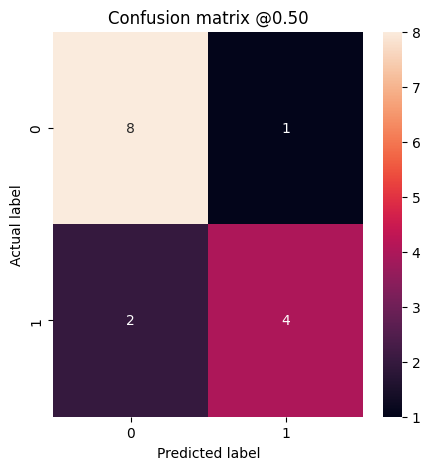

In [40]:
plot_cm(y_test, predictions_test)
plt.show()

In [41]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [42]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [43]:
#STOP

## 3 Dense Model with 16 Lines

### Dataset

In [44]:
# prepare dataset

df = df_damage_sixteen_mean.drop(columns=columns)

In [45]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 20)
Training labels shape: (106,) 

Validation features shape: (27, 20)
Validation labels shape: (27,) 

Test features shape: (15, 20)
Test labels shape: (15,) 



### Model

In [46]:
input_dim = X_train.shape[1]
units = 16
activation = 'relu'
output_size = 1
output_activation = 'sigmoid'
kernel_initializer = 'he_uniform'

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation }
]

model = DenseModel(LAYERS, input_dim)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                336       
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 177ms/step - loss: 0.7427 - tp: 39.0000 - fp: 52.0000 - tn: 15.0000 - fn: 15.0000 - accuracy: 0.4463 - precision: 0.4286 - recall: 0.7222 - auc: 0.5129 - prc: 0.5295 - val_loss: 0.8242 - val_tp: 9.0000 - val_fp: 15.0000 - val_tn: 2.0000 - val_fn: 1.0000 - val_accuracy: 0.4074 - val_precision: 0.3750 - val_recall: 0.9000 - val_auc: 0.3618 - val_prc: 0.2973
Epoch 2/50
4/4 [==============================] - 0s 22ms/step - loss: 0.7407 - tp: 35.0000 - fp: 51.0000 - tn: 7.0000 - fn: 13.0000 - accuracy: 0.3962 - precision: 0.4070 - recall: 0.7292 - auc: 0.4537 - prc: 0.5078 - val_loss: 0.8216 - val_tp: 9.0000 - val_fp: 15.0000 - val_tn: 2.0000 - val_fn: 1.0000 - val_accuracy: 0.4074 - val_precision: 0.3750 - val_recall: 0.9000 - val_auc: 0.3618 - val_prc: 0.2971
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 0.7393 - tp: 35.0000 - fp: 51.0000 - tn: 7.0000 - fn: 13.0000 - accuracy: 0.3962 - precision: 0.4070 - recall

Epoch 21/50
4/4 [==============================] - 0s 19ms/step - loss: 0.7142 - tp: 35.0000 - fp: 51.0000 - tn: 7.0000 - fn: 13.0000 - accuracy: 0.3962 - precision: 0.4070 - recall: 0.7292 - auc: 0.4966 - prc: 0.5519 - val_loss: 0.7767 - val_tp: 9.0000 - val_fp: 15.0000 - val_tn: 2.0000 - val_fn: 1.0000 - val_accuracy: 0.4074 - val_precision: 0.3750 - val_recall: 0.9000 - val_auc: 0.4529 - val_prc: 0.3311
Epoch 22/50
4/4 [==============================] - 0s 20ms/step - loss: 0.7132 - tp: 35.0000 - fp: 51.0000 - tn: 7.0000 - fn: 13.0000 - accuracy: 0.3962 - precision: 0.4070 - recall: 0.7292 - auc: 0.5009 - prc: 0.5548 - val_loss: 0.7745 - val_tp: 9.0000 - val_fp: 15.0000 - val_tn: 2.0000 - val_fn: 1.0000 - val_accuracy: 0.4074 - val_precision: 0.3750 - val_recall: 0.9000 - val_auc: 0.4559 - val_prc: 0.3326
Epoch 23/50
4/4 [==============================] - 0s 18ms/step - loss: 0.7119 - tp: 34.0000 - fp: 51.0000 - tn: 7.0000 - fn: 14.0000 - accuracy: 0.3868 - precision: 0.4000 - recal

Epoch 41/50
4/4 [==============================] - 0s 18ms/step - loss: 0.6950 - tp: 34.0000 - fp: 48.0000 - tn: 10.0000 - fn: 14.0000 - accuracy: 0.4151 - precision: 0.4146 - recall: 0.7083 - auc: 0.5519 - prc: 0.5929 - val_loss: 0.7433 - val_tp: 9.0000 - val_fp: 14.0000 - val_tn: 3.0000 - val_fn: 1.0000 - val_accuracy: 0.4444 - val_precision: 0.3913 - val_recall: 0.9000 - val_auc: 0.5765 - val_prc: 0.4229
Epoch 42/50
4/4 [==============================] - 0s 18ms/step - loss: 0.6942 - tp: 34.0000 - fp: 48.0000 - tn: 10.0000 - fn: 14.0000 - accuracy: 0.4151 - precision: 0.4146 - recall: 0.7083 - auc: 0.5553 - prc: 0.5959 - val_loss: 0.7419 - val_tp: 9.0000 - val_fp: 14.0000 - val_tn: 3.0000 - val_fn: 1.0000 - val_accuracy: 0.4444 - val_precision: 0.3913 - val_recall: 0.9000 - val_auc: 0.5794 - val_prc: 0.4238
Epoch 43/50
4/4 [==============================] - 0s 18ms/step - loss: 0.6933 - tp: 34.0000 - fp: 48.0000 - tn: 10.0000 - fn: 14.0000 - accuracy: 0.4151 - precision: 0.4146 - re

In [48]:
early_stopping.stopped_epoch

0

In [49]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [50]:
#plot_metrics(history)
#plt.show()

In [51]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_sixteen_mean.append(value)

1/1 [==============================] - 0s 21ms/step
loss :  0.7515673041343689
tp :  8.0
fp :  6.0
tn :  1.0
fn :  0.0
accuracy :  0.6000000238418579
precision :  0.5714285969734192
recall :  1.0
auc :  0.3392857015132904
prc :  0.4200737178325653


True Negatives:  1
False Positives:  6
False Negatives:  0
True Positives:  8
Total:  8


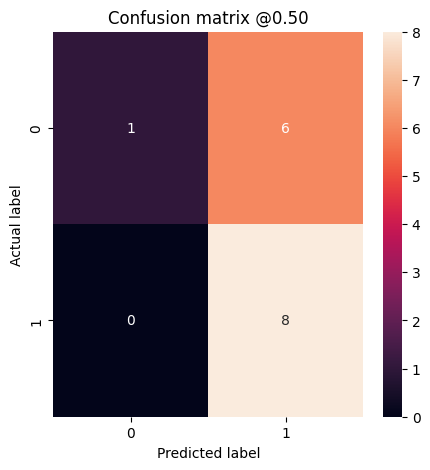

In [52]:
plot_cm(y_test, predictions_test)
plt.show()

In [53]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [54]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [55]:
#STOP

## 4 Dense Model with 32 Lines

### Dataset

In [56]:
# prepare dataset

df = df_damage_thirtytwo_mean.drop(columns=columns)

In [57]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 36)
Training labels shape: (106,) 

Validation features shape: (27, 36)
Validation labels shape: (27,) 

Test features shape: (15, 36)
Test labels shape: (15,) 



### Model

In [58]:
input_dim = X_train.shape[1]
units = 16
activation = 'relu'
output_size = 1
output_activation = 'sigmoid'
kernel_initializer = 'he_uniform'

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':units, 'activation': activation },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation }
]

model = DenseModel(LAYERS, input_dim)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                592       
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 172ms/step - loss: 0.7067 - tp: 22.0000 - fp: 18.0000 - tn: 46.0000 - fn: 35.0000 - accuracy: 0.5620 - precision: 0.5500 - recall: 0.3860 - auc: 0.5356 - prc: 0.5014 - val_loss: 0.6955 - val_tp: 5.0000 - val_fp: 6.0000 - val_tn: 10.0000 - val_fn: 6.0000 - val_accuracy: 0.5556 - val_precision: 0.4545 - val_recall: 0.4545 - val_auc: 0.5511 - val_prc: 0.4359
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 0.7040 - tp: 14.0000 - fp: 13.0000 - tn: 44.0000 - fn: 35.0000 - accuracy: 0.5472 - precision: 0.5185 - recall: 0.2857 - auc: 0.5240 - prc: 0.5339 - val_loss: 0.6919 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 11.0000 - val_fn: 6.0000 - val_accuracy: 0.5926 - val_precision: 0.5000 - val_recall: 0.4545 - val_auc: 0.5625 - val_prc: 0.4428
Epoch 3/50
4/4 [==============================] - 0s 18ms/step - loss: 0.7017 - tp: 12.0000 - fp: 12.0000 - tn: 45.0000 - fn: 37.0000 - accuracy: 0.5377 - precision: 0.5000 - reca

Epoch 21/50
4/4 [==============================] - 0s 19ms/step - loss: 0.6706 - tp: 12.0000 - fp: 10.0000 - tn: 47.0000 - fn: 37.0000 - accuracy: 0.5566 - precision: 0.5455 - recall: 0.2449 - auc: 0.6221 - prc: 0.5457 - val_loss: 0.6351 - val_tp: 5.0000 - val_fp: 3.0000 - val_tn: 13.0000 - val_fn: 6.0000 - val_accuracy: 0.6667 - val_precision: 0.6250 - val_recall: 0.4545 - val_auc: 0.7386 - val_prc: 0.7124
Epoch 22/50
4/4 [==============================] - 0s 18ms/step - loss: 0.6695 - tp: 12.0000 - fp: 10.0000 - tn: 47.0000 - fn: 37.0000 - accuracy: 0.5566 - precision: 0.5455 - recall: 0.2449 - auc: 0.6312 - prc: 0.5480 - val_loss: 0.6327 - val_tp: 5.0000 - val_fp: 3.0000 - val_tn: 13.0000 - val_fn: 6.0000 - val_accuracy: 0.6667 - val_precision: 0.6250 - val_recall: 0.4545 - val_auc: 0.7386 - val_prc: 0.7240
Epoch 23/50
4/4 [==============================] - 0s 17ms/step - loss: 0.6683 - tp: 13.0000 - fp: 10.0000 - tn: 47.0000 - fn: 36.0000 - accuracy: 0.5660 - precision: 0.5652 - re

Epoch 41/50
4/4 [==============================] - 0s 17ms/step - loss: 0.6527 - tp: 15.0000 - fp: 11.0000 - tn: 46.0000 - fn: 34.0000 - accuracy: 0.5755 - precision: 0.5769 - recall: 0.3061 - auc: 0.6847 - prc: 0.5851 - val_loss: 0.6093 - val_tp: 5.0000 - val_fp: 4.0000 - val_tn: 12.0000 - val_fn: 6.0000 - val_accuracy: 0.6296 - val_precision: 0.5556 - val_recall: 0.4545 - val_auc: 0.7244 - val_prc: 0.6873
Epoch 42/50
4/4 [==============================] - 0s 17ms/step - loss: 0.6520 - tp: 15.0000 - fp: 11.0000 - tn: 46.0000 - fn: 34.0000 - accuracy: 0.5755 - precision: 0.5769 - recall: 0.3061 - auc: 0.6880 - prc: 0.5881 - val_loss: 0.6087 - val_tp: 5.0000 - val_fp: 4.0000 - val_tn: 12.0000 - val_fn: 6.0000 - val_accuracy: 0.6296 - val_precision: 0.5556 - val_recall: 0.4545 - val_auc: 0.7244 - val_prc: 0.6873
Epoch 43/50
4/4 [==============================] - 0s 17ms/step - loss: 0.6513 - tp: 15.0000 - fp: 11.0000 - tn: 46.0000 - fn: 34.0000 - accuracy: 0.5755 - precision: 0.5769 - re

In [60]:
early_stopping.stopped_epoch

0

In [61]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [62]:
#plot_metrics(history)
#plt.show()

In [63]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_thirtytwo_mean.append(value)

1/1 [==============================] - 0s 19ms/step
loss :  0.7440334558486938
tp :  0.0
fp :  3.0
tn :  4.0
fn :  8.0
accuracy :  0.2666666805744171
precision :  0.0
recall :  0.0
auc :  0.4107142686843872
prc :  0.44347599148750305


True Negatives:  4
False Positives:  3
False Negatives:  8
True Positives:  0
Total:  8


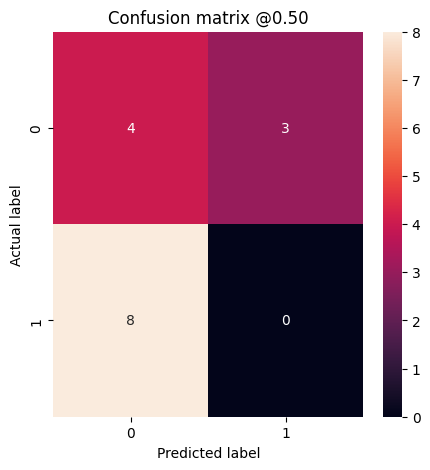

In [64]:
plot_cm(y_test, predictions_test)
plt.show()

In [65]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [66]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [67]:
#STOP

# 2 CNN Model

In [68]:
class CNNModel():
    def __init__(self, in_shape, n_classes, kernel_size=3, kernel_initializer='he_uniform', activation = 'relu', output_activation = 'sigmoid', pool_size=2, filters_1=8, filters_2=16, filters_3=32, filters_4=12, metrics=METRICS):
        model = Sequential()
        model.add(Conv1D(filters= filters_1, kernel_size = kernel_size, activation=activation, kernel_initializer=kernel_initializer, input_shape=in_shape))

        model.add(Conv1D(filters= filters_2, kernel_size = kernel_size, activation=activation, kernel_initializer=kernel_initializer))
        model.add(MaxPool1D(pool_size=pool_size))
        model.add(Dropout(0.5))

        #model.add(Conv1D(filters= filters_3, kernel_size = kernel_size, activation=activation, kernel_initializer=kernel_initializer))
        #model.add(MaxPool1D(pool_size=pool_size))
        #model.add(Dropout(0.5))

        model.add(Flatten())
        #model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        #model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
        #model.add(Dropout(0.5))
        #model.add(BatchNormalization())
        model.add(Dense(n_classes, activation=output_activation)) #'softmax'

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=metrics)
        
        self.model = model    

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, callback):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[callback])
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X): #X_train X_test
        predictions = self.model.predict(X)
        return predictions
    
    def summary(self):
        self.model.summary()
        
    def metrics_names(self):
        return self.model.metrics_names
        

## 5 CNN Model with 16 Lines

### Dataset

In [69]:
# prepare dataset

df = df_damage_sixteen_min_max.drop(columns=columns)

In [70]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 20)
Training labels shape: (106,) 

Validation features shape: (27, 20)
Validation labels shape: (27,) 

Test features shape: (15, 20)
Test labels shape: (15,) 



### Model

In [71]:
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

n_classes = len(unique(y_train))
n_classes = 1
print("Classes: {0}".format(n_classes))

model = CNNModel(in_shape, n_classes)
model.summary()

Before: (20,)
After: (20, 1)
Classes: 1
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 8)             32        
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 16)            400       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 16)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 8, 16)             0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 8)                 1032      
              

In [72]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 171ms/step - loss: 0.7832 - tp: 26.0000 - fp: 41.0000 - tn: 34.0000 - fn: 20.0000 - accuracy: 0.4959 - precision: 0.3881 - recall: 0.5652 - auc: 0.5767 - prc: 0.5885 - val_loss: 0.5636 - val_tp: 9.0000 - val_fp: 12.0000 - val_tn: 5.0000 - val_fn: 1.0000 - val_accuracy: 0.5185 - val_precision: 0.4286 - val_recall: 0.9000 - val_auc: 0.8706 - val_prc: 0.8988
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 0.6616 - tp: 28.0000 - fp: 32.0000 - tn: 36.0000 - fn: 10.0000 - accuracy: 0.6038 - precision: 0.4667 - recall: 0.7368 - auc: 0.7156 - prc: 0.7223 - val_loss: 0.5506 - val_tp: 9.0000 - val_fp: 9.0000 - val_tn: 8.0000 - val_fn: 1.0000 - val_accuracy: 0.6296 - val_precision: 0.5000 - val_recall: 0.9000 - val_auc: 0.8706 - val_prc: 0.8988
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 0.7579 - tp: 26.0000 - fp: 33.0000 - tn: 35.0000 - fn: 12.0000 - accuracy: 0.5755 - precision: 0.4407 - recal

Epoch 21/50
4/4 [==============================] - 0s 20ms/step - loss: 0.5816 - tp: 28.0000 - fp: 23.0000 - tn: 45.0000 - fn: 10.0000 - accuracy: 0.6887 - precision: 0.5490 - recall: 0.7368 - auc: 0.7842 - prc: 0.7768 - val_loss: 0.3996 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 1.0000 - val_accuracy: 0.8889 - val_precision: 0.8182 - val_recall: 0.9000 - val_auc: 0.9000 - val_prc: 0.9267
Epoch 22/50
4/4 [==============================] - 0s 23ms/step - loss: 0.6212 - tp: 26.0000 - fp: 28.0000 - tn: 40.0000 - fn: 12.0000 - accuracy: 0.6226 - precision: 0.4815 - recall: 0.6842 - auc: 0.7390 - prc: 0.7430 - val_loss: 0.3944 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 1.0000 - val_accuracy: 0.8889 - val_precision: 0.8182 - val_recall: 0.9000 - val_auc: 0.9000 - val_prc: 0.9267
Epoch 23/50
4/4 [==============================] - 0s 21ms/step - loss: 0.4974 - tp: 33.0000 - fp: 19.0000 - tn: 49.0000 - fn: 5.0000 - accuracy: 0.7736 - precision: 0.6346 - rec

Epoch 41/50
4/4 [==============================] - 0s 19ms/step - loss: 0.5383 - tp: 27.0000 - fp: 17.0000 - tn: 51.0000 - fn: 11.0000 - accuracy: 0.7358 - precision: 0.6136 - recall: 0.7105 - auc: 0.7980 - prc: 0.7858 - val_loss: 0.3246 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 15.0000 - val_fn: 1.0000 - val_accuracy: 0.8889 - val_precision: 0.8182 - val_recall: 0.9000 - val_auc: 0.9059 - val_prc: 0.9282
Epoch 42/50
4/4 [==============================] - 0s 19ms/step - loss: 0.4646 - tp: 31.0000 - fp: 15.0000 - tn: 53.0000 - fn: 7.0000 - accuracy: 0.7925 - precision: 0.6739 - recall: 0.8158 - auc: 0.8936 - prc: 0.8540 - val_loss: 0.3222 - val_tp: 9.0000 - val_fp: 1.0000 - val_tn: 16.0000 - val_fn: 1.0000 - val_accuracy: 0.9259 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9059 - val_prc: 0.9282
Epoch 43/50
4/4 [==============================] - 0s 19ms/step - loss: 0.4715 - tp: 29.0000 - fp: 12.0000 - tn: 56.0000 - fn: 9.0000 - accuracy: 0.8019 - precision: 0.7073 - reca

In [73]:
early_stopping.stopped_epoch

0

In [74]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [75]:
#plot_metrics(history)
#plt.show()

In [76]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_sixteen_min_max.append(value)

1/1 [==============================] - 0s 23ms/step
loss :  0.263361394405365
tp :  5.0
fp :  0.0
tn :  9.0
fn :  1.0
accuracy :  0.9333333373069763
precision :  1.0
recall :  0.8333333134651184
auc :  0.9074074029922485
prc :  0.9205749034881592


True Negatives:  9
False Positives:  0
False Negatives:  1
True Positives:  5
Total:  6


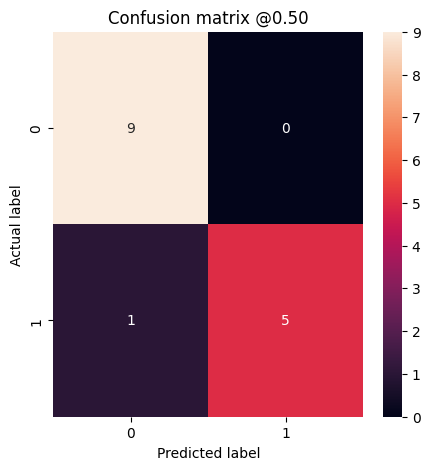

In [77]:
plot_cm(y_test, predictions_test)
plt.show()

In [78]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [79]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [80]:
#STOP

## 6 CNN Model with 32 Lines

### Dataset

In [81]:
# prepare dataset

df = df_damage_thirtytwo_min_max.drop(columns=columns)

In [82]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 36)
Training labels shape: (106,) 

Validation features shape: (27, 36)
Validation labels shape: (27,) 

Test features shape: (15, 36)
Test labels shape: (15,) 



### Model

In [83]:
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

n_classes = len(unique(y_train))
n_classes = 1
print("Classes: {0}".format(n_classes))

model = CNNModel(in_shape, n_classes)
model.summary()

Before: (36,)
After: (36, 1)
Classes: 1
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 34, 8)             32        
                                                                 
 conv1d_3 (Conv1D)           (None, 32, 16)            400       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16, 16)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16)            0         
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 8)                 2056      
              

In [84]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 198ms/step - loss: 1.1015 - tp: 17.0000 - fp: 16.0000 - tn: 54.0000 - fn: 34.0000 - accuracy: 0.5868 - precision: 0.5152 - recall: 0.3333 - auc: 0.4661 - prc: 0.5246 - val_loss: 1.1175 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 14.0000 - val_fn: 13.0000 - val_accuracy: 0.5185 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1813 - val_prc: 0.3397
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 0.9568 - tp: 12.0000 - fp: 11.0000 - tn: 50.0000 - fn: 33.0000 - accuracy: 0.5849 - precision: 0.5217 - recall: 0.2667 - auc: 0.4253 - prc: 0.4882 - val_loss: 1.0615 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 14.0000 - val_fn: 13.0000 - val_accuracy: 0.5185 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1786 - val_prc: 0.3386
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 1.1359 - tp: 13.0000 - fp: 15.0000 - tn: 46.0000 - fn: 32.0000 - accuracy:

Epoch 21/50
4/4 [==============================] - 0s 18ms/step - loss: 0.6473 - tp: 26.0000 - fp: 13.0000 - tn: 48.0000 - fn: 19.0000 - accuracy: 0.6981 - precision: 0.6667 - recall: 0.5778 - auc: 0.7058 - prc: 0.7403 - val_loss: 0.5322 - val_tp: 8.0000 - val_fp: 1.0000 - val_tn: 13.0000 - val_fn: 5.0000 - val_accuracy: 0.7778 - val_precision: 0.8889 - val_recall: 0.6154 - val_auc: 0.8379 - val_prc: 0.8699
Epoch 22/50
4/4 [==============================] - 0s 25ms/step - loss: 0.7480 - tp: 24.0000 - fp: 18.0000 - tn: 43.0000 - fn: 21.0000 - accuracy: 0.6321 - precision: 0.5714 - recall: 0.5333 - auc: 0.6113 - prc: 0.6004 - val_loss: 0.5219 - val_tp: 8.0000 - val_fp: 1.0000 - val_tn: 13.0000 - val_fn: 5.0000 - val_accuracy: 0.7778 - val_precision: 0.8889 - val_recall: 0.6154 - val_auc: 0.8489 - val_prc: 0.8793
Epoch 23/50
4/4 [==============================] - 0s 19ms/step - loss: 0.6067 - tp: 28.0000 - fp: 16.0000 - tn: 45.0000 - fn: 17.0000 - accuracy: 0.6887 - precision: 0.6364 - re

Epoch 41/50
4/4 [==============================] - 0s 18ms/step - loss: 0.5306 - tp: 34.0000 - fp: 11.0000 - tn: 50.0000 - fn: 11.0000 - accuracy: 0.7925 - precision: 0.7556 - recall: 0.7556 - auc: 0.8330 - prc: 0.8512 - val_loss: 0.4191 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 12.0000 - val_fn: 4.0000 - val_accuracy: 0.7778 - val_precision: 0.8182 - val_recall: 0.6923 - val_auc: 0.8791 - val_prc: 0.9048
Epoch 42/50
4/4 [==============================] - 0s 18ms/step - loss: 0.5386 - tp: 33.0000 - fp: 20.0000 - tn: 41.0000 - fn: 12.0000 - accuracy: 0.6981 - precision: 0.6226 - recall: 0.7333 - auc: 0.8055 - prc: 0.8125 - val_loss: 0.4164 - val_tp: 9.0000 - val_fp: 2.0000 - val_tn: 12.0000 - val_fn: 4.0000 - val_accuracy: 0.7778 - val_precision: 0.8182 - val_recall: 0.6923 - val_auc: 0.8819 - val_prc: 0.9058
Epoch 43/50
4/4 [==============================] - 0s 18ms/step - loss: 0.4536 - tp: 37.0000 - fp: 14.0000 - tn: 47.0000 - fn: 8.0000 - accuracy: 0.7925 - precision: 0.7255 - rec

In [85]:
early_stopping.stopped_epoch

0

In [86]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [87]:
#plot_metrics(history)
#plt.show()

In [88]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_thirtytwo_min_max.append(value)

1/1 [==============================] - 0s 22ms/step
loss :  0.2898629605770111
tp :  5.0
fp :  0.0
tn :  9.0
fn :  1.0
accuracy :  0.9333333373069763
precision :  1.0
recall :  0.8333333134651184
auc :  0.9814814329147339
prc :  0.9743082523345947


True Negatives:  9
False Positives:  0
False Negatives:  1
True Positives:  5
Total:  6


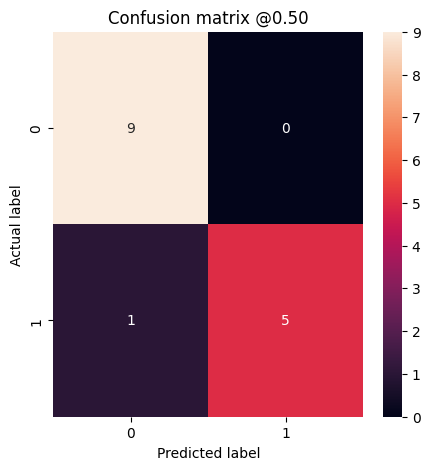

In [89]:
plot_cm(y_test, predictions_test)
plt.show()

In [90]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [91]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [92]:
#STOP

## 7 CNN Model with 16 Lines

### Dataset

In [93]:
# prepare dataset

df = df_damage_sixteen_mean.drop(columns=columns)

In [94]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 20)
Training labels shape: (106,) 

Validation features shape: (27, 20)
Validation labels shape: (27,) 

Test features shape: (15, 20)
Test labels shape: (15,) 



### Model

In [95]:
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

n_classes = len(unique(y_train))
n_classes = 1
print("Classes: {0}".format(n_classes))

model = CNNModel(in_shape, n_classes)
model.summary()

Before: (20,)
After: (20, 1)
Classes: 1
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 18, 8)             32        
                                                                 
 conv1d_5 (Conv1D)           (None, 16, 16)            400       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 8, 16)            0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 8, 16)             0         
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 8)                 1032      
              

In [96]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 3s 283ms/step - loss: 1.2483 - tp: 52.0000 - fp: 58.0000 - tn: 9.0000 - fn: 2.0000 - accuracy: 0.5041 - precision: 0.4727 - recall: 0.9630 - auc: 0.5565 - prc: 0.4765 - val_loss: 1.1736 - val_tp: 10.0000 - val_fp: 17.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.3704 - val_precision: 0.3704 - val_recall: 1.0000 - val_auc: 0.6029 - val_prc: 0.5950
Epoch 2/50
4/4 [==============================] - 0s 17ms/step - loss: 1.2235 - tp: 46.0000 - fp: 54.0000 - tn: 4.0000 - fn: 2.0000 - accuracy: 0.4717 - precision: 0.4600 - recall: 0.9583 - auc: 0.4944 - prc: 0.4508 - val_loss: 1.1440 - val_tp: 10.0000 - val_fp: 17.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.3704 - val_precision: 0.3704 - val_recall: 1.0000 - val_auc: 0.6059 - val_prc: 0.5960
Epoch 3/50
4/4 [==============================] - 0s 17ms/step - loss: 1.1687 - tp: 43.0000 - fp: 54.0000 - tn: 4.0000 - fn: 5.0000 - accuracy: 0.4434 - precision: 0

Epoch 21/50
4/4 [==============================] - 0s 18ms/step - loss: 0.9644 - tp: 38.0000 - fp: 49.0000 - tn: 9.0000 - fn: 10.0000 - accuracy: 0.4434 - precision: 0.4368 - recall: 0.7917 - auc: 0.4625 - prc: 0.4906 - val_loss: 0.7846 - val_tp: 10.0000 - val_fp: 17.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.3704 - val_precision: 0.3704 - val_recall: 1.0000 - val_auc: 0.7206 - val_prc: 0.6049
Epoch 22/50
4/4 [==============================] - 0s 17ms/step - loss: 1.0151 - tp: 38.0000 - fp: 48.0000 - tn: 10.0000 - fn: 10.0000 - accuracy: 0.4528 - precision: 0.4419 - recall: 0.7917 - auc: 0.4635 - prc: 0.4291 - val_loss: 0.7744 - val_tp: 10.0000 - val_fp: 17.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.3704 - val_precision: 0.3704 - val_recall: 1.0000 - val_auc: 0.7206 - val_prc: 0.6053
Epoch 23/50
4/4 [==============================] - 0s 17ms/step - loss: 0.7892 - tp: 43.0000 - fp: 52.0000 - tn: 6.0000 - fn: 5.0000 - accuracy: 0.4623 - precisi

Epoch 41/50
4/4 [==============================] - 0s 17ms/step - loss: 0.8624 - tp: 34.0000 - fp: 39.0000 - tn: 19.0000 - fn: 14.0000 - accuracy: 0.5000 - precision: 0.4658 - recall: 0.7083 - auc: 0.4957 - prc: 0.4871 - val_loss: 0.6458 - val_tp: 8.0000 - val_fp: 5.0000 - val_tn: 12.0000 - val_fn: 2.0000 - val_accuracy: 0.7407 - val_precision: 0.6154 - val_recall: 0.8000 - val_auc: 0.7559 - val_prc: 0.6134
Epoch 42/50
4/4 [==============================] - 0s 19ms/step - loss: 0.9312 - tp: 34.0000 - fp: 43.0000 - tn: 15.0000 - fn: 14.0000 - accuracy: 0.4623 - precision: 0.4416 - recall: 0.7083 - auc: 0.4522 - prc: 0.4238 - val_loss: 0.6421 - val_tp: 8.0000 - val_fp: 5.0000 - val_tn: 12.0000 - val_fn: 2.0000 - val_accuracy: 0.7407 - val_precision: 0.6154 - val_recall: 0.8000 - val_auc: 0.7529 - val_prc: 0.6100
Epoch 43/50
4/4 [==============================] - 0s 26ms/step - loss: 0.8432 - tp: 35.0000 - fp: 38.0000 - tn: 20.0000 - fn: 13.0000 - accuracy: 0.5189 - precision: 0.4795 - re

In [97]:
early_stopping.stopped_epoch

0

In [98]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [99]:
#plot_metrics(history)
#plt.show()

In [100]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        accuracy_sixteen_mean.append(value)

1/1 [==============================] - 0s 21ms/step
loss :  0.7852311730384827
tp :  2.0
fp :  4.0
tn :  3.0
fn :  6.0
accuracy :  0.3333333432674408
precision :  0.3333333432674408
recall :  0.25
auc :  0.3928571343421936
prc :  0.43644699454307556


True Negatives:  3
False Positives:  4
False Negatives:  6
True Positives:  2
Total:  8


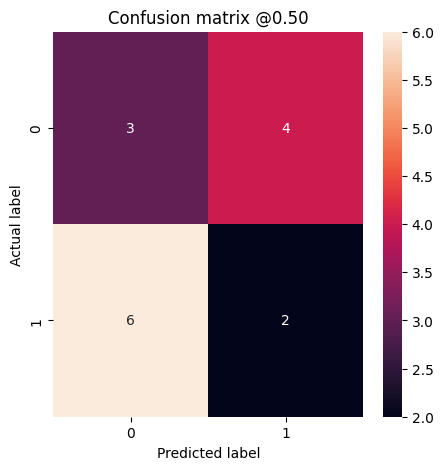

In [101]:
plot_cm(y_test, predictions_test)
plt.show()

In [102]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [103]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [104]:
#STOP

## 8 CNN Model with 32 Lines

### Dataset

In [105]:
# prepare dataset

df = df_damage_thirtytwo_mean.drop(columns=columns)

In [106]:
# Split into sets for training, validation, and testing + use and save scaler

X = df.drop(columns=['Damage'])
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

scaler_sixteen = StandardScaler()
X_train = scaler_sixteen.fit_transform(X_train)

X_val = scaler_sixteen.transform(X_val)
X_test = scaler_sixteen.transform(X_test)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Validation features shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape, '\n')

Training features shape: (106, 36)
Training labels shape: (106,) 

Validation features shape: (27, 36)
Validation labels shape: (27,) 

Test features shape: (15, 36)
Test labels shape: (15,) 



### Model

In [107]:
orig_shape = X_train.shape[1:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

in_shape = X_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

n_classes = len(unique(y_train))
n_classes = 1
print("Classes: {0}".format(n_classes))

model = CNNModel(in_shape, n_classes)
model.summary()

Before: (36,)
After: (36, 1)
Classes: 1
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 34, 8)             32        
                                                                 
 conv1d_7 (Conv1D)           (None, 32, 16)            400       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 16, 16)           0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16)            0         
                                                                 
 flatten_3 (Flatten)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 8)                 2056      
              

In [108]:
history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping)
#plt.plot(history.history['loss'])
#plt.show()

Epoch 1/50
4/4 [==============================] - 2s 184ms/step - loss: 1.0413 - tp: 29.0000 - fp: 40.0000 - tn: 24.0000 - fn: 28.0000 - accuracy: 0.4380 - precision: 0.4203 - recall: 0.5088 - auc: 0.4121 - prc: 0.4087 - val_loss: 1.3109 - val_tp: 5.0000 - val_fp: 14.0000 - val_tn: 2.0000 - val_fn: 6.0000 - val_accuracy: 0.2593 - val_precision: 0.2632 - val_recall: 0.4545 - val_auc: 0.2585 - val_prc: 0.2865
Epoch 2/50
4/4 [==============================] - 0s 22ms/step - loss: 0.9068 - tp: 25.0000 - fp: 30.0000 - tn: 27.0000 - fn: 24.0000 - accuracy: 0.4906 - precision: 0.4545 - recall: 0.5102 - auc: 0.4903 - prc: 0.4644 - val_loss: 1.2736 - val_tp: 5.0000 - val_fp: 14.0000 - val_tn: 2.0000 - val_fn: 6.0000 - val_accuracy: 0.2593 - val_precision: 0.2632 - val_recall: 0.4545 - val_auc: 0.2614 - val_prc: 0.2875
Epoch 3/50
4/4 [==============================] - 0s 20ms/step - loss: 1.0041 - tp: 23.0000 - fp: 29.0000 - tn: 28.0000 - fn: 26.0000 - accuracy: 0.4811 - precision: 0.4423 - reca

Epoch 21/50
4/4 [==============================] - 0s 21ms/step - loss: 0.8386 - tp: 19.0000 - fp: 14.0000 - tn: 43.0000 - fn: 30.0000 - accuracy: 0.5849 - precision: 0.5758 - recall: 0.3878 - auc: 0.5317 - prc: 0.4860 - val_loss: 0.8696 - val_tp: 5.0000 - val_fp: 13.0000 - val_tn: 3.0000 - val_fn: 6.0000 - val_accuracy: 0.2963 - val_precision: 0.2778 - val_recall: 0.4545 - val_auc: 0.3011 - val_prc: 0.3762
Epoch 22/50
4/4 [==============================] - 0s 20ms/step - loss: 0.7667 - tp: 21.0000 - fp: 18.0000 - tn: 39.0000 - fn: 28.0000 - accuracy: 0.5660 - precision: 0.5385 - recall: 0.4286 - auc: 0.5666 - prc: 0.5294 - val_loss: 0.8601 - val_tp: 6.0000 - val_fp: 13.0000 - val_tn: 3.0000 - val_fn: 5.0000 - val_accuracy: 0.3333 - val_precision: 0.3158 - val_recall: 0.5455 - val_auc: 0.3068 - val_prc: 0.3790
Epoch 23/50
4/4 [==============================] - 0s 19ms/step - loss: 0.8151 - tp: 20.0000 - fp: 26.0000 - tn: 31.0000 - fn: 29.0000 - accuracy: 0.4811 - precision: 0.4348 - re

Epoch 41/50
4/4 [==============================] - 0s 19ms/step - loss: 0.7782 - tp: 20.0000 - fp: 20.0000 - tn: 37.0000 - fn: 29.0000 - accuracy: 0.5377 - precision: 0.5000 - recall: 0.4082 - auc: 0.5295 - prc: 0.4737 - val_loss: 0.7223 - val_tp: 6.0000 - val_fp: 8.0000 - val_tn: 8.0000 - val_fn: 5.0000 - val_accuracy: 0.5185 - val_precision: 0.4286 - val_recall: 0.5455 - val_auc: 0.4489 - val_prc: 0.4598
Epoch 42/50
4/4 [==============================] - 0s 19ms/step - loss: 0.7637 - tp: 21.0000 - fp: 20.0000 - tn: 37.0000 - fn: 28.0000 - accuracy: 0.5472 - precision: 0.5122 - recall: 0.4286 - auc: 0.5553 - prc: 0.5261 - val_loss: 0.7141 - val_tp: 6.0000 - val_fp: 8.0000 - val_tn: 8.0000 - val_fn: 5.0000 - val_accuracy: 0.5185 - val_precision: 0.4286 - val_recall: 0.5455 - val_auc: 0.4659 - val_prc: 0.4635
Epoch 43/50
4/4 [==============================] - 0s 19ms/step - loss: 0.8166 - tp: 16.0000 - fp: 21.0000 - tn: 36.0000 - fn: 33.0000 - accuracy: 0.4906 - precision: 0.4324 - reca

In [109]:
early_stopping.stopped_epoch

0

In [110]:
#plot_loss(history, "Bias", 0)
#plt.show()

In [111]:
#plot_metrics(history)
#plt.show()

In [112]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

# Confusion matrix
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names(), results):
    print(name, ': ', value)
    if name == 'accuracy':
        print(value)
        accuracy_thirtytwo_mean.append(value)

1/1 [==============================] - 0s 21ms/step
loss :  0.7972513437271118
tp :  4.0
fp :  4.0
tn :  3.0
fn :  4.0
accuracy :  0.46666666865348816
0.46666666865348816
precision :  0.5
recall :  0.5
auc :  0.294642835855484
prc :  0.41083645820617676


True Negatives:  3
False Positives:  4
False Negatives:  4
True Positives:  4
Total:  8


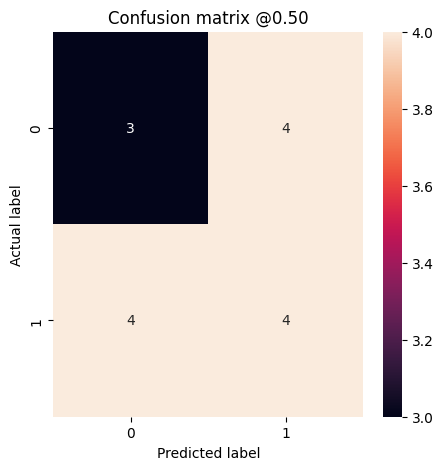

In [113]:
plot_cm(y_test, predictions_test)
plt.show()

In [114]:
#plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [115]:
# Precision-Recall Curve (PRC)
#plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
#plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
#plt.legend(loc='lower right')
#plt.show()

In [116]:
#STOP

In [117]:
print(accuracy_sixteen_min_max)
print(accuracy_thirtytwo_min_max)
print(accuracy_sixteen_mean)
print(accuracy_thirtytwo_mean)

[0.9333333373069763, 0.9333333373069763]
[0.800000011920929, 0.9333333373069763]
[0.6000000238418579, 0.3333333432674408]
[0.2666666805744171, 0.46666666865348816]


# Summarry

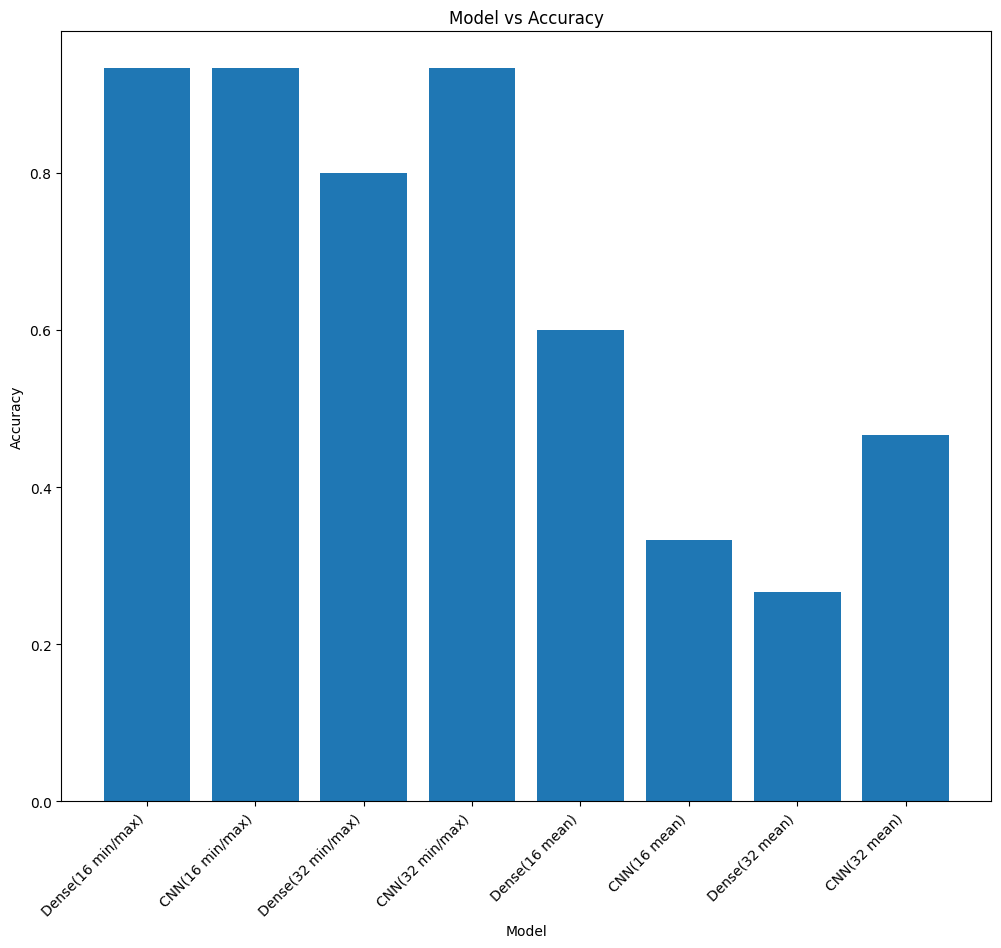

In [118]:
col = [1, 2, 3, 4, 5, 6, 7, 8]
accuracy = accuracy_sixteen_min_max + accuracy_thirtytwo_min_max + accuracy_sixteen_mean + accuracy_thirtytwo_mean

tick_label = ['Dense(16 min/max)', 'CNN(16 min/max)', 'Dense(32 min/max)', 'CNN(32 min/max)', 'Dense(16 mean)', 'CNN(16 mean)', 'Dense(32 mean)', 'CNN(32 mean)']

plt.bar(col, accuracy, tick_label = tick_label, width = 0.8)
    
plt.xticks(rotation=45, horizontalalignment="right")
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model vs Accuracy')

plt.show()   

In [119]:
#STOP